# Score-Based Generative Modeling

*Please note that this is an optional notebook meant to introduce more advanced concepts. If you’re up for a challenge, take a look and don’t worry if you can’t follow everything. There is no code to implement—only some cool code for you to learn and run!*

### Goals
This is a hitchhiker's guide to score-based generative models, a family of approaches based on [estimating gradients of the data distribution](https://arxiv.org/abs/1907.05600). They have obtained high-quality samples comparable to GANs (like below, figure from [this paper](https://arxiv.org/abs/2006.09011)) without requiring adversarial training, and are considered by some to be [the new contender to GANs](https://ajolicoeur.wordpress.com/the-new-contender-to-gans-score-matching-with-langevin-sampling/).

![ncsnv2](https://github.com/ermongroup/ncsnv2/blob/master/assets/samples.jpg?raw=true)



## Introduction

### Score and Score-Based Models
Given a probablity density function $p(\mathbf{x})$, we define the *score* as $$\nabla_\mathbf{x} \log p(\mathbf{x}).$$ As you might guess, score-based generative models are trained to estimate $\nabla_\mathbf{x} \log p(\mathbf{x})$. Unlike likelihood-based models such as flow models or autoregressive models, score-based models do not have to be normalized and are easier to parameterize. For example, consider a non-normalized statistical model $p_\theta(\mathbf{x}) = \frac{e^{-E_\theta(\mathbf{x})}}{Z_\theta}$, where $E_\theta(\mathbf{x}) \in \mathbb{R}$ is called the energy function and $Z_\theta$ is an unknown normalizing constant that makes $p_\theta(\mathbf{x})$ a proper probability density function. The energy function is typically parameterized by a flexible neural network. When training it as a likelihood model, we need to know the normalizing constant $Z_\theta$ by computing complex high-dimensional integrals, which is typically intractable. In constrast, when computing its score, we obtain $\nabla_\mathbf{x} \log p_\theta(\mathbf{x}) = -\nabla_\mathbf{x} E_\theta(\mathbf{x})$ which does not require computing the normalizing constant $Z_\theta$.

In fact, any neural network that maps an input vector $\mathbf{x} \in \mathbb{R}^d$ to an output vector $\mathbf{y} \in \mathbb{R}^d$ can be used as a score-based model, as long as the output and input have the same dimensionality. This yields huge flexibility in choosing model architectures.

### Perturbing Data with a Diffusion Process

In order to generate samples with score-based models, we need to consider a [diffusion process](https://en.wikipedia.org/wiki/Diffusion_process) that corrupts data slowly into random noise. Scores will arise when we reverse this diffusion process for sample generation. You will see this later in the notebook.

A diffusion process is a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process#:~:text=A%20stochastic%20or%20random%20process%20can%20be%20defined%20as%20a,an%20element%20in%20the%20set.) similar to [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). Their paths are like the trajectory of a particle submerged in a flowing fluid, which moves randomly due to unpredictable collisions with other particles. Let $\{\mathbf{x}(t) \in \mathbb{R}^d \}_{t=0}^T$ be a diffusion process, indexed by the continuous time variable $t\in [0,T]$. A diffusion process is governed by a stochastic differential equation (SDE), in the following form

\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}

where $\mathbf{f}(\cdot, t): \mathbb{R}^d \to \mathbb{R}^d$ is called the *drift coefficient* of the SDE, $g(t) \in \mathbb{R}$ is called the *diffusion coefficient*, and $\mathbf{w}$ represents the standard Brownian motion. You can understand an SDE as a stochastic generalization to ordinary differential equations (ODEs). Particles moving according to an SDE not only follows the deterministic drift $\mathbf{f}(\mathbf{x}, t)$, but are also affected by the random noise coming from $g(t) d\mathbf{w}$. 

For score-based generative modeling, we will choose a diffusion process such that $\mathbf{x}(0) \sim p_0$, where we have a dataset of i.i.d. samples, and $\mathbf{x}(T) \sim p_T$, for which we have a tractable form to sample from.

### Reversing the Diffusion Process Yields Score-Based Generative Models
By starting from a sample from $p_T$ and reversing the diffusion process, we will be able to obtain a sample from $p_\text{data}$. Crucially, the reverse process is a diffusion process running backwards in time. It is given by the following reverse-time SDE

\begin{align}
  d\mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g^2(t)\nabla_{\mathbf{x}}\log p_t(\mathbf{x})] dt + g(t) d\bar{\mathbf{w}},
\end{align}

where $\bar{\mathbf{w}}$ is a Brownian motion in the reverse time direction, and $dt$ here represents an infinitesimal negative time step. Here $p_t(\mathbf{x})$ represents the distribution of $\mathbf{x}(t)$. This reverse SDE can be computed once we know the drift and diffusion coefficients of the forward SDE, as well as the score of $p_t(\mathbf{x})$ for each $t\in[0, T]$.

The overall intuition of score-based generative modeling with SDEs can be summarized in the illustration below
![sde schematic](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/diffusion_schematic.jpg?raw=true)

### Score Estimation

Based on the above intuition, we can use the time-dependent score function $\nabla_\mathbf{x} \log p_t(\mathbf{x})$ to construct the reverse-time SDE, and then solve it numerically to obtain samples from $p_0$ using samples from a prior distribution $p_T$. We can train a time-dependent score-based model $s_\theta(\mathbf{x}, t)$ to approximate $\nabla_\mathbf{x} \log p_t(\mathbf{x})$, using the following weighted sum of [denoising score matching](http://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf) objectives.

\begin{align}
\min_\theta \mathbb{E}_{t\sim \mathcal{U}(0, T)} [\lambda(t) \mathbb{E}_{\mathbf{x}(0) \sim p_0(\mathbf{x})}\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2]],
\end{align}
where $\mathcal{U}(0,T)$ is a uniform distribution over $[0, T]$, $p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$ denotes the transition probability from $\mathbf{x}(0)$ to $\mathbf{x}(t)$, and $\lambda(t) \in \mathbb{R}^+$ denotes a continuous weighting function.

In the objective, the expectation over $\mathbf{x}(0)$ can be estimated with empirical means over data samples from $p_0$. The expectation over $\mathbf{x}(t)$ can be estimated by sampling from $p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$, which is efficient when the drift coefficient $\mathbf{f}(\mathbf{x}, t)$ is affine. The weight function $\lambda(t)$ is typically chosen to be inverse proportional to $\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) \|_2^2]$.



### Time-Dependent Score-Based Model

There are no restrictions on the network architecture of time-dependent score-based models, except that their output should have the same dimensionality as the input, and they should be conditioned on time.

Several useful tips on architecture choice:
* It usually performs well to use the [U-net](https://arxiv.org/abs/1505.04597) architecture as the backbone of the score network $s_\theta(\mathbf{x}, t)$,

* We can incorporate the time information via [Gaussian random features](https://arxiv.org/abs/2006.10739). Specifically, we first sample $\omega \sim \mathcal{N}(\mathbf{0}, s^2\mathbf{I})$ which is subsequently fixed for the model (i.e., not learnable). For a time step $t$, the corresponding Gaussian random feature is defined as 
\begin{align}
  [\sin(2\pi \omega t) ; \cos(2\pi \omega t)],
\end{align}
where $[\vec{a} ; \vec{b}]$ denotes the concatenation of vector $\vec{a}$ and $\vec{b}$. This Gaussian random feature can be used as an encoding for time step $t$ so that the score network can condition on $t$ by incorporating this encoding. We will see this further in the code.

* We can rescale the output of the U-net by $1/\sqrt{\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) \|_2^2]}$. This is because the optimal $s_\theta(\mathbf{x}(t), t)$ has an $\ell_2$-norm close to $\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))]\|_2$, and the rescaling helps capture the norm of the true score. Recall that the training objective contains sums of the form
\begin{align*}
\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2]].
\end{align*}
Therefore, it is natural to expect that the optimal score model $s_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}(t)} \log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$.

* Use [exponential moving average](https://discuss.pytorch.org/t/how-to-apply-exponential-moving-average-decay-for-variables/10856/3) (EMA) of weights when sampling. This can greatly improve sample quality, but requires slightly longer training time, and requires more work in implementation. We do not include this in this tutorial, but highly recommend it when you employ score-based generative modeling to tackle more challenging real problems.

In [1]:
#Defining a time-dependent score-based model (double click to expand or collapse)
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

class GridFourierProjection(nn.Module):
    def __init__(self, embed_dim, min_freq=0.125, max_freq=8.0):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.embed_dim = embed_dim
        self.half_embed_dim = math.ceil(embed_dim / 2.0)
        self.cut_embed_dim = False
        if self.embed_dim < 2 * self.half_embed_dim:
            self.cut_embed_dim = True
        period = torch.linspace(math.log(min_freq), math.log(max_freq), self.half_embed_dim)
        freq = 2.0 * math.pi * torch.exp(period)
        # self.W = nn.Parameter(torch.arange(1, N+1), requires_grad=False)
        self.register_buffer("W", freq)

        
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :]
        x_proj = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        if self.cut_embed_dim:
            x_proj = x_proj[..., :self.embed_dim]
        return x_proj
            

class GaussianFourierProjection__(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=8.0):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    
    def __init__(self, noise_scale, channels=[32, 64, 128, 256], embed_dim=256):
        """
          Initialize a time-dependent score-based network.

          noise_scale: 
            a function that takes time t and gives the variance of 
            the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: 
            the number of channels for feature maps of each resolution.
          embed_dim:
            the dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        # self.embed = GaussianFourierProjection(embed_dim=embed_dim)    
        self.embed = GridFourierProjection(embed_dim=embed_dim)    
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(
            channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(
            channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.noise_scale = noise_scale
  
    def forward(self, x, t): 
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t))    
        # Encoding path
        h1 = self.conv1(x)    
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output based on the norm of perturbation kernels.
        h = h / self.noise_scale(t)[:, None, None, None]
        return h

## Training with Weighted Sum of Denoising Score Matching Objectives

Now let's get our hands dirty on training. First of all, we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE
\begin{align*}
d \mathbf{x} = \sqrt{\frac{d [\sigma^2(t)]}{dt}} d\mathbf{w},
\end{align*}
where $\sigma(t) = \sigma_{\text{min}}(\frac{\sigma_{\text{max}}}{\sigma_{\text{min}}})^t$, $t\in[0,1]$. In this case,
\begin{align*}
p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) = \mathcal{N}(\mathbf{x}(t); \mathbf{x}(0), [\sigma^2(t) - \sigma^2(0)]\mathbf{I})
\end{align*}
and $\lambda(t) \propto \sigma^2(t) - \sigma^2(0)$.

When $\sigma_{\text{max}}$ is large enough, the distribution of $p_1$ is 
\begin{align*}
\int p_0(\mathbf{y})\mathcal{N}(\mathbf{x}; \mathbf{y}, [\sigma_{\text{max}}^2 - \sigma_{\text{min}}^2]\mathbf{I}) d \mathbf{y} \approx \mathbf{N}(\mathbf{x}; \mathbf{0}, [\sigma_{\text{max}}^2 - \sigma_{\text{min}}^2]\mathbf{I}),
\end{align*}
which is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\sigma(t)^2 - \sigma^2(0)$, where $\sigma(t)$ is a strictly increasing function that grows exponentially fast. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_0$ to a simple Gaussian distribution $p_1$.

In [2]:
# Loss function (double click to expand or collapse)
def noise_scale(t, sigma_min=0.01, sigma_max=10, grad=False):
    """
    Compute quantities related to the perturbation kernel p_{0t}(x(t) | x(0)).

    t: a vector of time steps.
    sigma_min: the minimum value of the sigma function.
    sigma_max: the maximum value of the sigma function.
    grad: if False, only return the variance of p_{0t}(x(t) | x(0)). 
    Otherwise return both the variance and the gradient of sigma^2(t).
    This gradient will be useful for sample generation.
    """
    noise = sigma_min * (sigma_max / sigma_min)**t
    
    if not grad:
        return torch.sqrt(noise**2 - sigma_min**2)
    
    dnoise_dt = sigma_min * (sigma_max / sigma_min)**t * np.log(sigma_max/sigma_min)
    dnoise2_dt = 2 * noise * dnoise_dt
    return torch.sqrt(noise**2 - sigma_min**2), dnoise2_dt

def loss_func(model, x, noise_scale, eps=1e-3):
    """
    The loss function for training score-based generative models.

    model: a PyTorch model instance that represents a time-dependent score-based model.
    x: a mini-batch of input images.
    noise_scale: a function that computes the variance of perturbation kernels.
    eps: a tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    noise_scales = noise_scale(random_t)
    z = torch.randn_like(x)
    perturbed_x = x + z * noise_scales[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.sum((score * noise_scales[:, None, None, None] + z).reshape(x.shape[0], -1)**2, dim=-1).mean()
    return loss

In [3]:
#Training
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm.auto import tqdm, trange

device = 'cuda:3'

sigma_min = 0.01
sigma_max = 22
noise_scale_func = functools.partial(noise_scale, sigma_min=sigma_min, sigma_max=sigma_max, grad=False)
score_model = ScoreNet(noise_scale=noise_scale_func)
# score_model = torch.nn.DataParallel(ScoreNet(noise_scale=noise_scale_func))
score_model = score_model.to(device)


In [4]:
n_epochs =  300
## size of a mini-batch
batch_size =  32
## learning rate
lr=1e-4 

dataset = MNIST('../data', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


optimizer = Adam(score_model.parameters(), lr=lr)
series = []
for epoch in trange(n_epochs):
    avg_loss = 0.
    num_items = 0
    for x, y in data_loader:
        optimizer.zero_grad()
        x = x.to(device)    
        loss = loss_func(score_model, x, noise_scale_func)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss so far.
    # print(f'epoch: {epoch}, average loss: {avg_loss / num_items}')
    # Save one checkpoint after each epoch of training.
    series.append(avg_loss / num_items)
    torch.save(score_model.state_dict(), f'../data/score_based_gen_model_grid.pth')

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

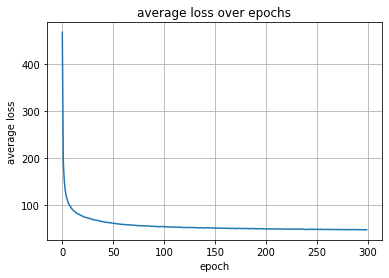

In [6]:
plt.plot(series);
plt.title('average loss over epochs')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid(True);

## Sampling with Numerical SDE Solvers
Recall that for any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt + g(t) d\mathbf{w},
\end{align*}
the reverse-time SDE is given by
\begin{align*}
d \mathbf{x} = [\mathbf{f}(\mathbf{x}, t) + g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})] dt + g(t) d \bar{\mathbf{w}}.
\end{align*}
Since we have chosen the forward SDE to be
\begin{align*}
d \mathbf{x} = \sqrt{\frac{d [\sigma^2(t)]}{dt}} d\mathbf{w},
\end{align*}
where $\sigma(t) = \sigma_{\text{min}}(\frac{\sigma_{\text{max}}}{\sigma_{\text{min}}})^t$, $t\in[0,1]$. The reverse-time SDE is given by
\begin{align*}
d\mathbf{x} = -\frac{d[\sigma^2(t)]}{dt} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sqrt{\frac{d[\sigma^2(t)]}{d t}} d \bar{\mathbf{w}}.
\end{align*}
To sample from our time-dependent score-based model $s_\theta(\mathbf{x}, t)$, we can first draw a sample from $p_1 \approx \mathbf{N}(\mathbf{x}; \mathbf{0}, [\sigma_{\text{max}}^2 - \sigma_{\text{min}}^2]\mathbf{I})$, and then solve the reverse-time SDE with numerical methods.

Specifically, using our time-dependent score-based model, the reverse-time SDE can be approximated by
\begin{align*}
d\mathbf{x} = -\frac{d[\sigma^2(t)]}{dt} s_\theta(\mathbf{x}, t) dt + \sqrt{\frac{d[\sigma^2(t)]}{d t}} d \bar{\mathbf{w}}
\end{align*}

Next, one can use numerical methods to solve for the reverse-time SDE, such as the [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) approach. It is based on a simple discretization to the SDE, replacing $dt$ with $\Delta t$ and $d \mathbf{w}$ with $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, g^2(t) \Delta t \mathbf{I})$. When applied to our reverse-time SDE, we can obtain the following iteration rule
\begin{align}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + \frac{d[\sigma^2(t)]}{dt}s_\theta(\mathbf{x}_t, t)\Delta t + \sqrt{\frac{d[\sigma^2(t)]}{dt}\Delta t} \mathbf{z}_t,
\end{align}
where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

## Sampling with Predictor-Corrector Methods

Aside from generic numerical SDE solvers, we can leverage special properties of our reverse-time SDE for better solutions. Since we have an estimate of the score of $p_t(\mathbf{x}(t))$ via the score-based model, i.e., $s_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}(t)} \log p_t(\mathbf{x}(t))$, we can leverage score-based MCMC approaches, such as Langevin MCMC, to correct the solution obtained by numerical SDE solvers.

Score-based MCMC approaches can produce samples from a distribution $p(\mathbf{x})$ once its score $\nabla_\mathbf{x} \log p(\mathbf{x})$ is known. For example, Langevin MCMC operates by running the following iteration rule for $i=1,2,\cdots, N$:
\begin{align*}
\mathbf{x}_{i+1} = \mathbf{x}_{i} + \epsilon \nabla_\mathbf{x} \log p(\mathbf{x}_i) + \sqrt{2\epsilon} \mathbf{z}_i,
\end{align*}
where $\mathbf{z}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, $\epsilon > 0$ is the step size, and $\mathbf{x}_1$ is initialized from any prior distribution $\pi(\mathbf{x}_1)$. When $N\to\infty$ and $\epsilon \to 0$, the final value $\mathbf{x}_{N+1}$ becomes a sample from $p(\mathbf{x})$ under some regularity conditions. Therefore, given $s_\theta(\mathbf{x}, t) \approx \nabla_\mathbf{x} \log p_t(\mathbf{x})$, we can get an approximate sample from $p_t(\mathbf{x})$ by running several steps of Langevin MCMC, replacing $\nabla_\mathbf{x} \log p_t(\mathbf{x})$ with $s_\theta(\mathbf{x}, t)$ in the iteration rule.

Predictor-Corrector samplers combine both numerical solvers for the reverse-time SDE and the Langevin MCMC approach. In particular, we first apply one step of numerical SDE solver to obtain $\mathbf{x}_{t-\Delta t}$ from $\mathbf{x}_t$, which is called the "predictor" step. Next, we apply several steps of Langevin MCMC to refine $\mathbf{x}_t$, such that $\mathbf{x}_t$ becomes a more accurate sample from $p_{t-\Delta t}(\mathbf{x})$. This is the "corrector" step as the MCMC helps reduce the error of the numerical SDE solver. 

## Sampling with Numerical ODE Solvers

For any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}
there exists an associated ordinary differential equation (ODE)
\begin{align*}
d \mathbf{x} = \bigg[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2}g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})\bigg] dt,
\end{align*}
such that their trajectories have the same mariginal probability density $p_t(\mathbf{x})$. We call this ODE the *probability flow ODE*.

Therefore, we can start from a sample from $p_T$, integrate the ODE in the reverse time direction, and then get a sample from $p_0 = p_\text{data}$. In particular, for our chosen forward SDE, we can integrate the following SDE from $t=T$ to $0$ for sample generation
\begin{align*}
d\mathbf{x} =  -\frac{1}{2}\frac{d[\sigma^2(t)]}{d t} s_\theta(\mathbf{x}, t) dt.
\end{align*}
This can be done using many heavily-optimized black-box ODE solvers provided by packages such as `scipy`.

In [7]:
# SDE sampling (double click to expand or collapse)

## The number of sampling steps.
num_steps = 5000
@torch.no_grad()
def sde_sampler(score_model, noise_scale, batch_size=64, num_steps=num_steps, device='cuda'):
    """
    Generate samples from score-based models with numerical SDE solvers.

    score_model: a PyTorch model that represents the time-dependent score-based model.
    noise_scale: a function that gives a tuple: (the variance of p_{0t}(x(t) | x(0)) and
    , the gradient of sigma^2(t) ).
    batch_size: the number of samplers to generate by calling this function once.
    num_steps: the number of sampling steps. Also equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * noise_scale(t)[0][:, None, None, None]
    time_steps = np.linspace(1.0, 1e-3, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    for time_step in tqdm(time_steps):      
        batch_time_step = torch.ones(batch_size, device=device) * time_step
        next_x = x + noise_scale(batch_time_step)[1][:, None, None, None] * score_model(x, batch_time_step) * step_size
        next_x = next_x + torch.sqrt(noise_scale(batch_time_step)[1] * step_size)[:, None, None, None] * torch.randn_like(x)
    x = next_x       
    return x

In [8]:
# PC sampling

signal_to_noise_ratio = 0.15
num_steps = 1000

@torch.no_grad()
def pc_sampler(score_model, noise_scale, batch_size=64, num_steps=num_steps, snr=signal_to_noise_ratio, 
               device='cuda'):
    """
    Generate samples from score-based models with Predictor-Corrector method.

    score_model: a PyTorch model that represents the time-dependent score-based model.
    noise_scale: a function that gives a tuple: (the variance of p_{0t}(x(t) | x(0)) and
    , the gradient of sigma^2(t) ).
    batch_size: the number of samplers to generate by calling this function once.
    num_steps: the number of sampling steps. Also equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * noise_scale(t)[0][:, None, None, None]
    time_steps = np.linspace(1., 1e-3, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    for time_step in tqdm(time_steps):      
        # Corrector step
        batch_time_step = torch.ones(batch_size, device=device) * time_step
        next_x = x + noise_scale(batch_time_step)[1][:, None, None, None] * score_model(x, batch_time_step) * step_size
        next_x = next_x + torch.sqrt(noise_scale(batch_time_step)[1] * step_size)[:, None, None, None] * torch.randn_like(x)
        x = next_x 

        # Predictor step
        grad = score_model(x, batch_time_step)
        grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
        noise_norm = np.sqrt(np.prod(x.shape[1:]))
        langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
        x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      
    return x

In [9]:
# ODE sampling (double click to expand or collapse)
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5

@torch.no_grad()
def ode_sampler(score_model, noise_scale, batch_size=64, atol=error_tolerance, rtol=error_tolerance, 
                device='cuda', z=None):
    """
    Generate samples from score-based models with black-box ODE solvers.

    score_model: a PyTorch model that represents the time-dependent score-based model.
    noise_scale: a function that gives a tuple: (the variance of p_{0t}(x(t) | x(0)) and
    , the gradient of sigma^2(t) ).
    batch_size: the number of samplers to generate by calling this function once.
    atol: tolerance of absolute errors.
    rtol: tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: the latent code that governs the final sample. If None, we start from p_1;
    otherwise, we start from the given z.
    """
    t = torch.ones(batch_size, device=device)
    # Create the latent code
    if z is None:
        init_x = torch.randn(batch_size, 1, 28, 28, device=device) * noise_scale(t)[0][:, None, None, None]
    else:
        init_x = z
    
    shape = init_x.shape

    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
        score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
    def ode_func(t, x):        
        """The ODE function for use by the ODE solver."""
        time_steps = np.ones((shape[0],)) * t

        return  -0.5 * noise_scale(torch.tensor(t))[1].cpu().numpy() * score_eval_wrapper(x, time_steps)    
  
    # Run the black-box ODE solver.
    res = integrate.solve_ivp(ode_func, (1., 1e-2), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

    return x

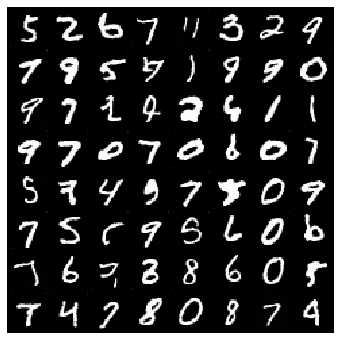

In [10]:
#Sampling
from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda:3'
ckpt = torch.load(f'../data/score_based_gen_model_grid.pth', map_location=device)
score_model.load_state_dict(ckpt)

noise_scale_func = functools.partial(noise_scale, sigma_min=sigma_min, sigma_max=sigma_max, grad=True)
sample_batch_size = 64

# sampler = sde_sampler
sampler = pc_sampler
# sampler = ode_sampler

## Generate samples using the specified sampler.
samples = sampler(score_model, noise_scale_func, sample_batch_size, device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)

sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

## Likelihood Computation

A by-product of the probability flow ODE formulation is likelihood computation. Suppose we have a differentiable one-to-one mapping $\mathbf{h}$ that transforms a data sample $\mathbf{x} \sim p_0$ to a prior distribution $\mathbf{h}(\mathbf{x}) \sim p_1$. We can compute the likelihood of $p_0(\mathbf{x})$ via the following [change-of-variable formula](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function)
\begin{align*}
p_0(\mathbf{x}) = p_1(\mathbf{h}(\mathbf{x})) |\operatorname{det}(J_\mathbf{h}(\mathbf{x}))|,
\end{align*}
where $J_\mathbf{h}(\mathbf{x})$ represents the Jacobian of the mapping $\mathbf{h}$, and we assume it is efficient to evaluate the likelihood of the prior distribution $p_1$. 

Similarly, an ODE is also a one-to-one mapping from $\mathbf{x}(0)$ to $\mathbf{x}(1)$. For ODEs of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt,
\end{align*}
there exists an [instantaneous change-of-variable formula](https://arxiv.org/abs/1806.07366) that connects the probability of $p_0(\mathbf{x})$ and $p_1(\mathbf{x})$, given by
\begin{align*}
p_0 (\mathbf{x}(0)) = e^{\int_0^1 \operatorname{div} \mathbf{f}(\mathbf{x}(t), t) d t} p_1(\mathbf{x}(1)),
\end{align*}
where $\operatorname{div}$ denotes the divergence function (trace of Jacobian). 

In practice, this divergence function can be hard to evaluate for general vector-valued function $\mathbf{f}$, but we can use an unbiased estimator, named [Skilling-Hutchinson estimator](http://blog.shakirm.com/2015/09/machine-learning-trick-of-the-day-3-hutchinsons-trick/), to approximate the trace. Let $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. The Skilling-Hutchinson estimator is based on the fact that
\begin{align*}
\operatorname{div} \mathbf{f}(\mathbf{x}) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_\mathbf{f}(\mathbf{x}) \boldsymbol\epsilon].
\end{align*}
Therefore, we can simply sample a random vector $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, and then use $\boldsymbol \epsilon^\intercal J_\mathbf{f}(\mathbf{x}) \boldsymbol \epsilon$ to estimate the divergence of $\mathbf{f}(\mathbf{x})$. This estimator only requires computing the Jacobian-vector product $J_\mathbf{f}(\mathbf{x})\boldsymbol \epsilon$, which is typically efficient.

As a result, for our probability flow ODE, we can compute the (log) data likelihood with the following
\begin{align*}
\log p_0(\mathbf{x}(0)) = \log p_1(\mathbf{x}(1)) -\frac{1}{2}\int_0^1 \frac{d[\sigma^2(t)]}{dt} \operatorname{div} s_\theta(\mathbf{x}(t), t) dt.
\end{align*}
With the Skilling-Hutchinson estimator, we can compute the divergence via
\begin{align*}
\operatorname{div} s_\theta(\mathbf{x}(t), t) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_{s_\theta}(\mathbf{x}(t), t) \boldsymbol\epsilon].
\end{align*}
Afterwards, we can compute the integral with numerical integrators. This gives us an unbiased estimate to the true data likelihood, and we can make it more and more accurate when we run it multiple times and take the average. The numerical integrator requires $\mathbf{x}(t)$ as a function of $t$, which can be obtained by solving the original probability flow ODE.

In [ ]:
#@title Likelihood function (double click to expand or collapse)

def prior_likelihood(z, sigma):
  """The likelihood of a Gaussian distribution with mean zero and 
      standard deviation sigma."""
  shape = z.shape
  N = np.prod(shape[1:])
  return -N / 2. * torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=(1,2,3)) / (2 * sigma**2)

def ode_likelihood(x, score_model, noise_scale, batch_size=64, device='cuda'):

  # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
  epsilon = torch.randn_like(x)
      
  def divergence_eval(sample, time_steps, epsilon):      
    """Compute the divergence of the score-based model with Skilling-Hutchinson."""
    with torch.enable_grad():
      sample.requires_grad_(True)
      score_e = torch.sum(score_model(sample, time_steps) * epsilon)
      grad_score_e = torch.autograd.grad(score_e, sample)[0]
    return torch.sum(grad_score_e * epsilon, dim=(1, 2, 3))    
  
  shape = x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the score-based model for the black-box ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def divergence_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the divergence of score for the black-box ODE solver."""
    with torch.no_grad():
      # Obtain x(t) by solving the probability flow ODE.
      sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
      time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
      # Compute likelihood.
      div = divergence_eval(sample, time_steps, epsilon)
      return div.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):
    """The ODE function for the black-box solver."""
    time_steps = np.ones((shape[0],)) * t    
    sample = x[:-shape[0]]
    logp = x[-shape[0]:]
    sample_grad = -0.5 * noise_scale(torch.tensor(t))[1].cpu().numpy() * score_eval_wrapper(sample, time_steps)
    logp_grad = -0.5 * noise_scale(torch.tensor(t))[1].cpu().numpy() * divergence_eval_wrapper(sample, time_steps)
    return np.concatenate([sample_grad, logp_grad], axis=0)

  init = np.concatenate([x.cpu().numpy().reshape((-1,)), np.zeros((shape[0],))], axis=0)
  # Black-box ODE solver
  res = integrate.solve_ivp(ode_func, (1e-3, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')  
  zp = torch.tensor(res.y[:, -1], device=device)
  z = zp[:-shape[0]].reshape(shape)
  delta_logp = zp[-shape[0]:].reshape(shape[0])
  sigma_max = noise_scale(torch.ones((), device=device))[0]
  prior_logp = prior_likelihood(z, sigma_max)
  bpd = -(prior_logp + delta_logp) / np.log(2)
  N = np.prod(shape[1:])
  bpd = bpd / N + 8.
  return z, bpd

In [ ]:
# Computing likelihood on the dataset (double click to expand or collapse)

ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

noise_scale_func = functools.partial(noise_scale, sigma_min=sigma_min, sigma_max=sigma_max, grad=True)

all_bpds = 0.
all_items = 0
try:
  for x, _ in tqdm.notebook.tqdm(data_loader):
    x = x.to(device)
    # uniform dequantization
    x = (x * 255. + torch.rand_like(x)) / 256.    
    _, bpd = ode_likelihood(x, score_model, noise_scale_func, x.shape[0], device=device)
    all_bpds += bpd.sum()
    all_items += bpd.shape[0]
    print(f"bpd (running average): {all_bpds / all_items}")
  print(f"bpd (full average): {all_bpds/all_items}")
except KeyboardInterrupt:
  # Remove the error message when interuptted by keyboard or GUI.
  pass


bpd (running average): 2.3032925728249083
bpd (running average): 2.308977756601495
bpd (running average): 2.377123575058273
bpd (running average): 2.389343318526081
bpd (running average): 2.370500455404197
bpd (running average): 2.378673716580655
bpd (running average): 2.382435482845119
bpd (running average): 2.4092268406606396



## Further Resources

If you're interested in learning more about score-based generative models, the following papers would be a good start:

*   Yang Song, and Stefano Ermon. "[Generative modeling by estimating gradients of the data distribution.](https://arxiv.org/pdf/1907.05600.pdf)" Advances in Neural Information Processing Systems. 2019.
*    Yang Song, and Stefano Ermon. "[Improved Techniques for Training Score-Based Generative Models.](https://arxiv.org/pdf/2006.09011.pdf)" Advances in Neural Information Processing Systems. 2020.
* Jonathan Ho, Ajay Jain, and Pieter Abbeel. "[Denoising diffusion probabilistic models.](https://arxiv.org/pdf/2006.11239.pdf)" Advances in Neural Information Processing Systems. 2020.